In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
def make_train_df(rating,clothes,user):
    df = pd.merge(rating,user,how='inner',on='R_id')
    df = pd.merge(df,clothes,how='inner',on='image')
    df=df.drop(columns=['스타일선호','mar','job','income','r_style1','r_style2','r_style3','r_style4','r_style5'])
    df_rating = df['선호여부']
    df = df.drop(columns=['선호여부'])
    encoder = OneHotEncoder(sparse_output=False)
    #print(df.head())
    df_encoded = encoder.fit_transform(df.loc[:,'r_gender':'분위기'])
    
    df_encoded = pd.DataFrame(df_encoded,columns= [f"col{i}_{elem}" for i,sublist in enumerate(encoder.categories_) for elem in sublist])
    #df = pd.concat([df[['R_id','image']],df_encoded,df.loc[:,'멋있다':].astype(np.int8)],axis=1)
    df = pd.concat([df_encoded,df.loc[:,'멋있다':]],axis=1)
    #df = df_encoded

    return df,df_rating,encoder

In [3]:
def make_test_df(rating,clothes,user,encoder):
    df = pd.merge(rating,user,how='inner',on='R_id')
    df = pd.merge(df,clothes,how='inner',on='image')
    
    df=df.drop(columns=['스타일선호','mar','job','income','r_style1','r_style2','r_style3','r_style4','r_style5'])
    df_rating = df['선호여부']
    df = df.drop(columns=['선호여부'])
    df_encoded = encoder.transform(df.loc[:,'r_gender':'분위기'])
    df_encoded = pd.DataFrame(df_encoded,columns= [f"col{i}_{elem}" for i,sublist in enumerate(encoder.categories_) for elem in sublist])
    #df = pd.concat([df[['R_id','image']],df_encoded,df.loc[:,'멋있다':].astype(np.int8)],axis=1)
    df = pd.concat([df_encoded,df.loc[:,'멋있다':]],axis=1)
    #df = df_encoded
    return df,df_rating

In [4]:
rating = pd.read_csv('../preprocessed/TL_woman_rating_2019.csv')
clothes = pd.read_csv('../preprocessed/TL_woman_clothes_2019.csv',index_col='image')
user = pd.read_csv('../preprocessed/TL_woman_user_2019.csv',index_col='R_id')

train_x,train_y,encoder = make_train_df(rating,clothes,user)

In [5]:
train_x.to_csv('../train/train_x_woman.csv',index=False)
train_y.to_csv('../train/train_y_woman.csv',index=False)

In [6]:
with open('../encoder/onehot_encoder_woman.pkl','wb') as f:
    pickle.dump(encoder,f)

In [7]:
rating = pd.read_csv('../preprocessed/VL_woman_rating_2019.csv')
clothes = pd.read_csv('../preprocessed/VL_woman_clothes_2019.csv',index_col='image')
user = pd.read_csv('../preprocessed/VL_woman_user_2019.csv',index_col='R_id')

In [8]:
test_x,test_y = make_test_df(rating,clothes,user,encoder)

In [9]:
reg = RandomForestRegressor(random_state=0,n_jobs=-1)
reg.fit(train_x,train_y)

RandomForestRegressor(n_jobs=-1, random_state=0)

In [10]:
ftr_importances_values = reg.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=train_x.columns)
ftr_top = ftr_importances.sort_values(ascending=False)[:20]

ftr_top

독특하다             0.117350
깔끔하다             0.040489
실용적이다            0.026553
col1_30대         0.023268
col1_20대         0.022865
트렌디하다            0.022454
활동적이다            0.022421
무난하다             0.021904
col1_40대         0.021363
편안하다             0.021287
세련되다             0.021219
도시적이다            0.021113
발랄하다             0.020726
col2_summer      0.019403
여성적이다            0.018959
멋있다              0.018670
부드럽다             0.018660
col5_normcore    0.018266
col7_봄/가을        0.017830
col4_triangle    0.017278
dtype: float64

In [11]:
import math
from sklearn.metrics import mean_squared_error
train_predict = reg.predict(train_x)
print("RMSE:{}".format(math.sqrt(mean_squared_error(train_predict, train_y))) )

RMSE:0.3136099496099953


In [12]:
test_predict = reg.predict(test_x)
print("RMSE':{}".format(math.sqrt(mean_squared_error(test_predict, test_y))) )

RMSE':0.7729973117505007


In [13]:
from sklearn.metrics import classification_report
def map_to_binary(value):
    if value<3.0:
        return 0
    return 1

train_predict_binary = np.vectorize(map_to_binary)(train_predict)
train_y_binary = np.vectorize(map_to_binary)(train_y)
test_predict_binary = np.vectorize(map_to_binary)(test_predict)
test_y_binary = np.vectorize(map_to_binary)(test_y)


In [42]:
print(classification_report(train_y_binary,train_predict_binary))

              precision    recall  f1-score   support

           0       0.58      1.00      0.73      7516
           1       1.00      0.46      0.63     10027

    accuracy                           0.69     17543
   macro avg       0.79      0.73      0.68     17543
weighted avg       0.82      0.69      0.67     17543



In [43]:
print(classification_report(test_y_binary,test_predict_binary))

              precision    recall  f1-score   support

           0       0.49      0.93      0.65      1033
           1       0.86      0.30      0.44      1405

    accuracy                           0.57      2438
   macro avg       0.67      0.61      0.54      2438
weighted avg       0.70      0.57      0.53      2438



In [18]:
def precision_at_k(rating_,predict_value,k):
    rating_df = pd.read_csv(rating_)
    predict_df = pd.DataFrame({'예측': predict_value})
    rating_df = pd.concat([rating_df,predict_df],axis=1)

    precisions = []

    for user in rating_df['R_id'].unique():
        if len(rating_df[rating_df['R_id']==user])>=2:
            pred = rating_df.loc[rating_df['R_id'] == user,['image','선호여부','예측']].sort_values(by='예측',ascending=False).reset_index(drop=True)
            pred_k = pred.head(k)
            precision = len(pred_k.loc[pred_k['선호여부']>=3.0]) / float(k)
            precisions.append(precision)
                
    return sum(precisions) / len(precisions)


def recall_at_k(rating_,predict_value,k):
    rating_df = pd.read_csv(rating_)
    
    predict_df = pd.DataFrame({'예측': predict_value})
 
    rating_df = pd.concat([rating_df,predict_df],axis=1)
    recalls = []

  
    for user in rating_df['R_id'].unique():
        if len(rating_df[rating_df['R_id']==user])>=2:
            pred = rating_df.loc[rating_df['R_id']==user,['image','선호여부','예측']].sort_values(by='예측',ascending=False).reset_index(drop=True)
            pred_k = pred.head(k)
            recall = len(pred_k.loc[pred_k['선호여부']>=3.0]) / len(pred.loc[pred['선호여부']>=3.0]) if len(pred.loc[pred['선호여부']>=3.0])>0 else 0
            recalls.append(recall)

    return sum(recalls) / len(recalls)

In [15]:
k=10
print(f"precision@{k} of train: ",precision_at_k('../preprocessed/TL_woman_rating_2019.csv',train_predict,k))
print(f"recall@10 of train: ",recall_at_k('../preprocessed/TL_woman_rating_2019.csv',train_predict,k))

precision@10 of train:  0.35128295254833036
recall@10 of train:  0.9491799188385999


In [46]:

print(f"precision@{k} of test: ",precision_at_k('../preprocessed/VL_woman_rating_2019.csv',test_predict,k))
print(f"recall@{k} of test: ",recall_at_k('../preprocessed/VL_woman_rating_2019.csv',test_predict,k))

precision@10 of test:  0.13938356164383595
recall@10 of test:  0.839041095890411


In [19]:
pre_train=[0]*11
rec_train=[0]*11
pre_test=[0]*11
rec_test=[0]*11
for i in range(1,12):
    pre_train[i-1] = precision_at_k('../preprocessed/TL_woman_rating_2019.csv',train_predict,i)
    rec_train[i-1]=recall_at_k('../preprocessed/TL_woman_rating_2019.csv',train_predict,i)
    pre_test[i-1]=precision_at_k('../preprocessed/VL_woman_rating_2019.csv',test_predict,i)
    rec_test[i-1]=recall_at_k('../preprocessed/VL_woman_rating_2019.csv',test_predict,i)

In [20]:
for i in range(1,12):
    print(f"precision@{i} of train: {pre_train[i-1]}")
    print(f"recall@{i} of train: {rec_train[i-1]}")
    print(f"precision@{i} of test: {pre_test[i-1]}")
    print(f"recall@{i} of test: {rec_test[i-1]}")

precision@1 of train: 0.9472759226713533
recall@1 of train: 0.34020225491320155
precision@1 of test: 0.7294520547945206
recall@1 of test: 0.49472031963470325
precision@2 of train: 0.901054481546573
recall@2 of train: 0.5888989445071272
precision@2 of test: 0.6164383561643836
recall@2 of test: 0.7742579908675804
precision@3 of train: 0.8345635618043347
recall@3 of train: 0.7612043042826439
precision@3 of test: 0.4514840182648407
recall@3 of test: 0.8263413242009133
precision@4 of train: 0.7494727592267135
recall@4 of train: 0.8638845908302938
precision@4 of test: 0.3467465753424658
recall@4 of test: 0.8371860730593608
precision@5 of train: 0.6604569420035116
recall@5 of train: 0.9188320127030715
precision@5 of test: 0.2787671232876719
recall@5 of test: 0.839041095890411
precision@6 of train: 0.5735207967193892
recall@6 of train: 0.9404988253198401
precision@6 of test: 0.2323059360730597
recall@6 of test: 0.839041095890411
precision@7 of train: 0.4981672106452401
recall@7 of train: 0.946

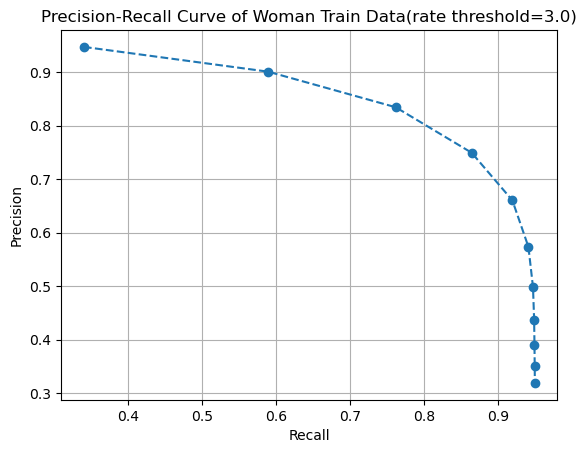

In [21]:
import matplotlib.pyplot as plt

plt.plot(rec_train,pre_train,"o--")
plt.title("Precision-Recall Curve of Woman Train Data(rate threshold=3.0)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()


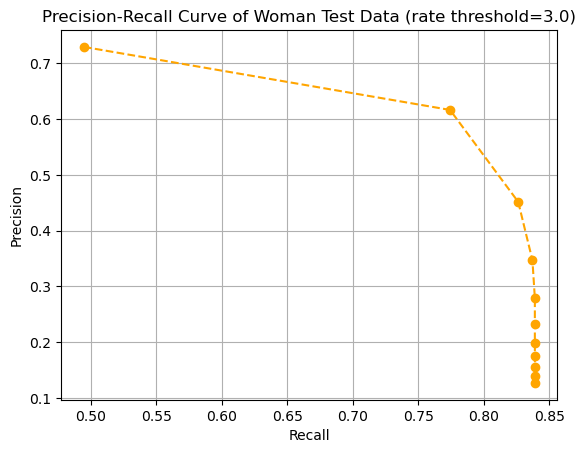

In [22]:
plt.plot(rec_test,pre_test,"o--",color='orange')
plt.title("Precision-Recall Curve of Woman Test Data (rate threshold=3.0)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()

In [23]:
def precision_at_k_by_personal(rating_,user_,predict_value,k):
    rating_df = pd.read_csv(rating_)
    user_df = pd.read_csv(user_)
    predict_df = pd.DataFrame({'예측': predict_value})
    rating_df = rating_df.merge(user_df,how='inner',on='R_id')
    rating_df = pd.concat([rating_df,predict_df],axis=1)

    precisions = []

    for color in rating_df['personal_color'].unique():
        for face in rating_df['faceshape'].unique():
            for body in rating_df['bodyshape'].unique():

                pred = rating_df.loc[(rating_df['personal_color']==color) & (rating_df['faceshape']==face) & (rating_df['bodyshape']==body),['image','선호여부','예측']].sort_values(by='예측',ascending=False).reset_index(drop=True)
                pred_k =pred.head(k)
                if len(pred_k)>0:
                    precision = len(pred_k.loc[pred_k['선호여부']>=3.0]) / float(k)
                    precisions.append(precision)

    return sum(precisions) / len(precisions)


def recall_at_k_by_personal(rating_,user_,predict_value,k):
    rating_df = pd.read_csv(rating_)
    user_df = pd.read_csv(user_)
    predict_df = pd.DataFrame({'예측': predict_value})
    rating_df = rating_df.merge(user_df,how='inner',on='R_id')
    rating_df = pd.concat([rating_df,predict_df],axis=1)
    recalls = []

    for color in rating_df['personal_color'].unique():
        for face in rating_df['faceshape'].unique():
            for body in rating_df['bodyshape'].unique():

                pred = rating_df.loc[(rating_df['personal_color']==color) & (rating_df['faceshape']==face) & (rating_df['bodyshape']==body),['image','선호여부','예측']].sort_values(by='예측',ascending=False).reset_index(drop=True)
                pred_k = pred.head(k)
                if len(pred_k)>0:
                    recall = len(pred_k.loc[pred_k['선호여부']>=3.0]) / len(pred.loc[pred['선호여부']>=3.0]) if len(pred.loc[pred['선호여부']>=3.0])>0 else 0
                    recalls.append(recall)

    return sum(recalls) / len(recalls)

In [48]:
k=10
print(f"precision@{k} of train" , precision_at_k_by_personal('../preprocessed/TL_woman_rating_2019.csv','../preprocessed/TL_woman_user_2019.csv',train_predict,k))
print(f"recall@{k} of train" , recall_at_k_by_personal('../preprocessed/TL_woman_rating_2019.csv','../preprocessed/TL_woman_user_2019.csv',train_predict,k))

precision@10 of train 0.9510204081632654
recall@10 of train 0.33362503972571933


In [49]:
print(f"precision@{k} of test: ",precision_at_k_by_personal('../preprocessed/VL_woman_rating_2019.csv','../preprocessed/VL_woman_user_2019.csv',test_predict,k))
print(f"recall@{k} of test: ",recall_at_k_by_personal('../preprocessed/VL_woman_rating_2019.csv','../preprocessed/VL_woman_user_2019.csv',test_predict,k))

precision@10 of test:  0.6069767441860466
recall@10 of test:  0.6221385899471726


In [24]:
pre_train_per=[0]*11
rec_train_per=[0]*11
pre_test_per=[0]*11
rec_test_per=[0]*11
for i in range(1,12):
    pre_train_per[i-1] = precision_at_k_by_personal('../preprocessed/TL_woman_rating_2019.csv','../preprocessed/TL_woman_user_2019.csv',train_predict,i)
    rec_train_per[i-1]=recall_at_k_by_personal('../preprocessed/TL_woman_rating_2019.csv','../preprocessed/TL_woman_user_2019.csv',train_predict,i)
    pre_test_per[i-1]=precision_at_k_by_personal('../preprocessed/VL_woman_rating_2019.csv','../preprocessed/VL_woman_user_2019.csv',test_predict,i)
    rec_test_per[i-1]=recall_at_k_by_personal('../preprocessed/VL_woman_rating_2019.csv','../preprocessed/VL_woman_user_2019.csv',test_predict,i)

In [25]:
for i in range(1,12):
    print(f"precision@{i} of train: {pre_train_per[i-1]}")
    print(f"recall@{i} of train: {rec_train_per[i-1]}")
    print(f"precision@{i} of test: {pre_test_per[i-1]}")
    print(f"recall@{i} of test: {rec_test_per[i-1]}")

precision@1 of train: 1.0
recall@1 of train: 0.045858454733828796
precision@1 of test: 0.9069767441860465
recall@1 of test: 0.1658705055188001
precision@2 of train: 1.0
recall@2 of train: 0.09171690946765759
precision@2 of test: 0.8372093023255814
recall@2 of test: 0.27569019277747964
precision@3 of train: 1.0
recall@3 of train: 0.13757536420148642
precision@3 of test: 0.7984496124031009
recall@3 of test: 0.35346853636690845
precision@4 of train: 0.9897959183673469
recall@4 of train: 0.16982837675844445
precision@4 of test: 0.7441860465116279
recall@4 of test: 0.40012754709281845
precision@5 of train: 0.9836734693877551
recall@5 of train: 0.20208138931540254
precision@5 of test: 0.7488372093023257
recall@5 of test: 0.46996015424813886
precision@6 of train: 0.9795918367346939
recall@6 of train: 0.2343344018723606
precision@6 of test: 0.7248062015503876
recall@6 of test: 0.5204510002421763
precision@7 of train: 0.9737609329446064
recall@7 of train: 0.26318605388510097
precision@7 of test

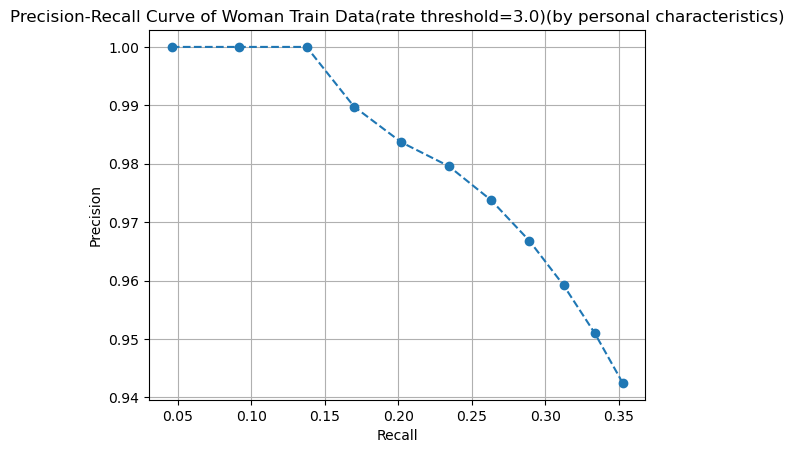

In [26]:
plt.plot(rec_train_per,pre_train_per,"o--")
plt.title("Precision-Recall Curve of Woman Train Data(rate threshold=3.0)(by personal characteristics)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()

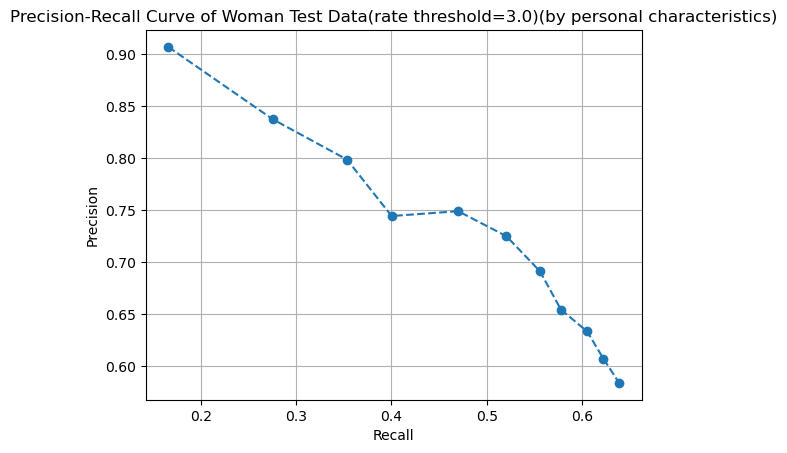

In [27]:
plt.plot(rec_test_per,pre_test_per,"o--")
plt.title("Precision-Recall Curve of Woman Test Data(rate threshold=3.0)(by personal characteristics)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()

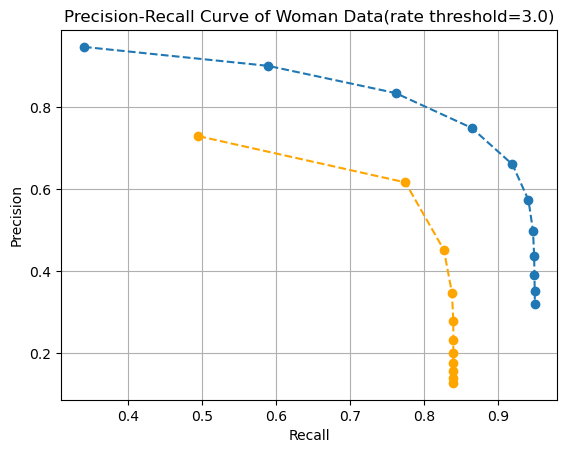

In [28]:
plt.plot(rec_train,pre_train,"o--",label='Train Data')
plt.plot(rec_test,pre_test,"o--",color='orange',label='Test Data')
plt.title("Precision-Recall Curve of Woman Data(rate threshold=3.0)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()

In [50]:
def recommend_internal(clothes_path,encoder_path,gender,age,color,face,body):
    
    df_user=pd.DataFrame.from_dict({'r_gender':[gender],'age':[age],'personal_color':[color],'faceshape':[face],'bodyshape':[body]})
    df_clothes = pd.read_csv(clothes_path)
    df = pd.concat([df_user,df_clothes],axis=1)
    df = df.ffill()
    df_clothes_name = df['image']
    df = df.drop(columns=['image'])

    encoder = ''
    with open(encoder_path,'rb') as f:
        encoder = pickle.load(f)
    df_encoded = encoder.transform(df.loc[:,'r_gender':'분위기'])
    df_encoded = pd.DataFrame(df_encoded,columns= [f"col{i}_{elem}" for i,sublist in enumerate(encoder.categories_) for elem in sublist])
    df_test = pd.concat([df_encoded,df.loc[:,'멋있다':].astype(np.int8)],axis=1)

    predict = reg.predict(df_test)
    rating = pd.DataFrame.from_dict({'rating':predict})
    return pd.concat([df_clothes_name,rating],axis=1).sort_values(by=['rating'], axis=0, ascending=False)

In [51]:
#참고
pd.read_csv('../preprocessed/TL_woman_rating_2019.csv')['R_id'].value_counts().value_counts()
#training data에는 아이디당 5~7개 옷 평가

count
6     816
7     712
5     469
8     359
4     278
3     128
2      38
1      14
16     13
15     10
25      4
20      4
22      3
18      2
19      2
23      2
40      2
11      1
21      1
24      1
Name: count, dtype: int64

In [52]:
#참고
pd.read_csv('../preprocessed/VL_woman_rating_2019.csv')['R_id'].value_counts().value_counts()
#training data에는 아이디당 1~2개 옷 평가

count
1    1008
2     407
3     118
4      33
5      26
Name: count, dtype: int64

In [53]:
recommend_internal('../preprocessed/TL_woman_clothes_2019.csv','../encoder/onehot_encoder_woman.pkl','여성','20대','spring','round','round').head(n=10)

,image,rating
4827,W_07708_19_normcore_W.jpg,3.710000
4615,W_05429_19_normcore_W.jpg,3.710000
1028,T_06247_19_normcore_W.jpg,3.706667
1030,T_06252_19_normcore_W.jpg,3.675000
11928,W_69663_19_normcore_W.jpg,3.656667
3826,T_14752_19_normcore_W.jpg,3.626667
3944,T_15674_19_normcore_W.jpg,3.625000
657,T_05226_19_normcore_W.jpg,3.610000
7606,W_37378_19_normcore_W.jpg,3.607500
4531,W_04139_19_normcore_W.jpg,3.606667


In [54]:
recommend_internal('../preprocessed/TL_woman_clothes_2019.csv','../encoder/onehot_encoder_woman.pkl','여성','20대','winter','oval','round').head(n=10)

,image,rating
4010,T_16402_19_normcore_W.jpg,3.695000
591,T_05113_19_normcore_W.jpg,3.686667
2222,T_10262_19_normcore_W.jpg,3.650000
5068,W_09078_19_normcore_W.jpg,3.600000
5908,W_20074_19_normcore_W.jpg,3.560000
3234,T_13333_19_normcore_W.jpg,3.550000
2500,T_10726_19_normcore_W.jpg,3.540000
13019,W_92359_19_normcore_W.jpg,3.540000
3680,T_14527_19_normcore_W.jpg,3.540000
5433,W_13147_19_normcore_W.jpg,3.530000


In [55]:
import joblib
joblib.dump(reg, '../model/random_woman.pkl') 

['../model/random_woman.pkl']